# Arbitrage Pricing Theory
---

Arbitrage pricing theory is a major asset pricing theory that relies on expressing the returns using a linear factor model:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

This theory states that if we have modelled our rate of return as above, then the expected returns obey

$$ E(R_i) = R_F + b_{i1} \lambda_1 + b_{i2} \lambda_2 + \ldots + b_{iK} \lambda_K $$

where $R_F$ is the risk-free rate, and $\lambda_j$ is the risk premium - the return in excess of the risk-free rate - for factor $j$. This premium arises because investors require higher returns to compensate them for incurring risk. This generalizes the capital asset pricing model (CAPM), which uses the return on the market as its only factor.

We can compute $\lambda_j$ by constructing a portfolio that has a sensitivity of 1 to factor $j$ and 0 to all others (called a <i>pure factor portfolio</i> for factor $j$), and measure its return in excess of the risk-free rate. Alternatively, we could compute the factor sensitivities for $K$ well-diversified (no asset-specific risk, i.e. $\epsilon_p = 0$) portfolios, and then solve the resulting system of linear equations.

## Arbitrage

There are generally many, many securities in our universe. If we use different ones to compute the $\lambda$s, will our results be consistent? If our results are inconsistent, there is an <i>arbitrage opportunity</i> (in expectation). Arbitrage is an operation that earns a profit without incurring risk and with no net investment of money, and an arbitrage opportunity is an opportunity to conduct such an operation. In this case, we mean that there is a risk-free operation with <i>expected</i> positive return that requires no net investment. It occurs when expectations of returns are inconsistent, i.e. risk is not priced consistently across securities.

For instance, there is an arbitrage opportunity in the following case: say there is an asset with expected rate of return 0.2 for the next year and a $\beta$ of 1.2 with the market, while the market is expected to have a rate of return of 0.1, and the risk-free rate on 1-year bonds is 0.05. Then the APT model tells us that the expected rate of return on the asset should be

$$ R_F + \beta \lambda = 0.05 + 1.2 (0.1 - 0.05) = 0.11$$

This does not agree with the prediction that the asset will have a rate of return of 0.2. So, if we buy \$100 of our asset, short \$120 of the market, and buy \$20 of bonds, we will have invested no net money and are not exposed to any systematic risk (we are market-neutral), but we expect to earn $0.2 \cdot 100 - 0.1 \cdot 120 + 20 \cdot 0.05 = 9$ dollars at the end of the year.

The APT assumes that these opportunities will be taken advantage of until prices shift and the arbitrage opportunities disappear. That is, it assumes that there are arbitrageurs who have sufficient amounts of patience and capital. This provides a justification for the use of empirical factor models in pricing securities: if the model were inconsistent, there would be an arbitrage opportunity, and so the prices would adjust.

##Goes Both Ways

Often knowing $E(R_i)$ is incredibly difficult, but notice that this model tells us what the expected returns should be if the market is fully arbitraged. This lays the groundwork for long-short equity strategies based on factor model ranking systems. If you know what the expected return of an asset is given that the market is arbitraged, and you hypothesize that the market will be mostly arbitraged over the timeframe on which you are trading, then you can construct a ranking.

##Long-Short Equity

To do this, estimate the expected return for each asset on the market, then rank them. Long the top percentile and short the bottom percentile, and you will make money on the difference in returns. Said another way, if the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, and assets at the bottom tend to make $5\%$ less, then you will make $(M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ percent per year, where $M$ is the market return that gets canceled out.

Long-short equity accepts that any individual asset is very difficult to model, relies on broad trends holding true. We can't accurately predict expected returns for an asset, but we can predict the expected returns for a group of 1000 assets as the errors average out.


##How many factors do you want?

Regarding Overfitting, having more factors will explain more and more of your returns, but at the cost of being more and more fit to noise in your data. Do discover true signals and make good predictions going forward, you want to select as few parameters as possible that still explain a large amount of the variance in returns.

##Example: Computing Expected Returns for Two Assets

In [1]:
import numpy as np
import pandas as pd
from statsmodels import regression
import matplotlib.pyplot as plt

Import in data

In [2]:
start_date = '2014-06-30'
end_date = '2015-06-30'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2014-07-31'
offset_end_date = '2015-07-31'

# Get returns data for our assets
asset1 = get_pricing('HSC', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
asset2 = get_pricing('MSFT', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

In [3]:
# Define a constant to compute intercept
constant = pd.TimeSeries(np.ones(len(asset1.index)), index=asset1.index)

df = pd.DataFrame({'R1': asset1,
              'R2': asset2,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

We'll start by computing static regressions over the whole time period.

In [4]:
OLS_model = regression.linear_model.OLS(df['R1'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
print 'p-value', fitted_model.f_pvalue
print fitted_model.params
R1_params = fitted_model.params

OLS_model = regression.linear_model.OLS(df['R2'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
print 'p-value', fitted_model.f_pvalue
print fitted_model.params
R2_params = fitted_model.params

p-value 6.68669273225e-26
SPY         1.768275
RF         -8.594705
Constant   -0.002203
dtype: float64
p-value 6.48439859144e-23
SPY         1.208441
RF          5.352250
Constant   -0.000133
dtype: float64


These numbers don't tell us too much by themselves. We need to look at the distribution of estimated coefficients and whether it's stable. Look at the rolling 100-day regression.

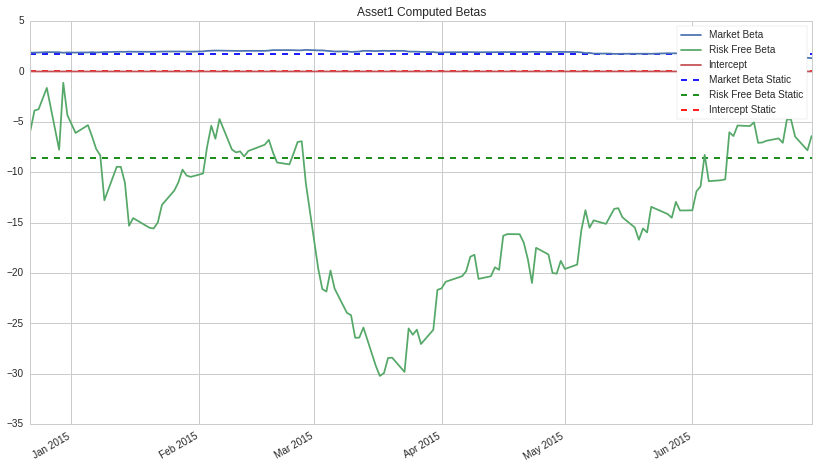

In [5]:
model = pd.stats.ols.MovingOLS(y = df['R1'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R1_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R1_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset1 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);

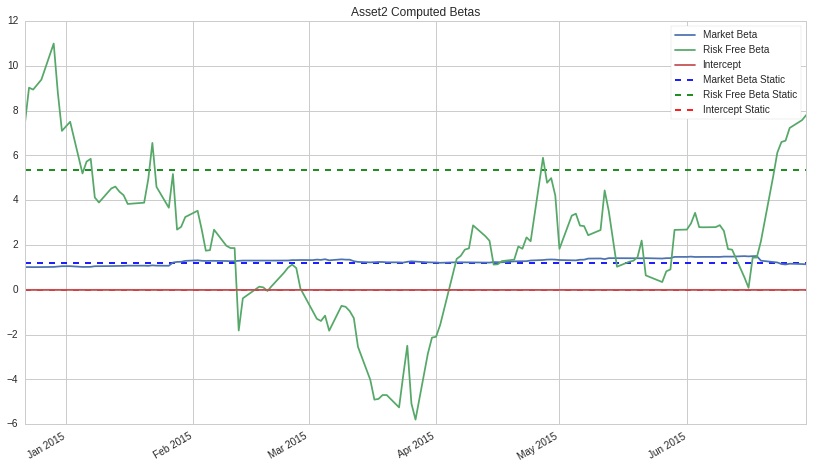

In [6]:
model = pd.stats.ols.MovingOLS(y = df['R2'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R2_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R2_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R2_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);

It might seem like the market betas are stable here, now we zoom in to reassess

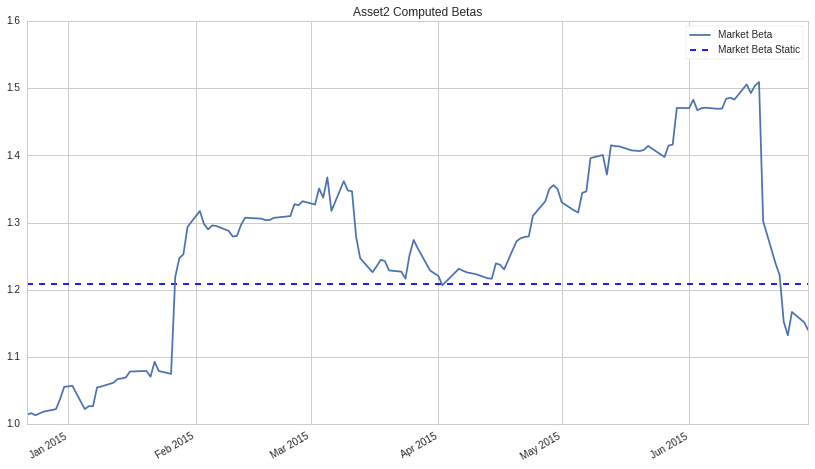

In [7]:
model = pd.stats.ols.MovingOLS(y = df['R2'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();

plt.hlines(R2_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);

As you can see, the plot scale massively affects how we perceive estimate quality.

##Predicting the Future

This model predicts future prices for these assets.

In [8]:
start_date = '2014-07-25'
end_date = '2015-07-25'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2014-08-25'
offset_end_date = '2015-08-25'

# Get returns data for our assets
asset1 = get_pricing('HSC', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]


# Define a constant to compute intercept
constant = pd.TimeSeries(np.ones(len(asset1.index)), index=asset1.index)

df = pd.DataFrame({'R1': asset1,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

We'll perform a historical regression to get our model parameter estimates.

In [9]:
OLS_model = regression.linear_model.OLS(df['R1'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
print 'p-value', fitted_model.f_pvalue
print fitted_model.params

b_SPY = fitted_model.params['SPY']
b_RF = fitted_model.params['RF']
a = fitted_model.params['Constant']

p-value 3.74649506793e-24
SPY         1.738003
RF         -7.382430
Constant   -0.002555
dtype: float64


Get the factor data for the last month so we can predict the next month.

In [10]:
start_date = '2015-07-25'
end_date = '2015-08-25'

# Get returns for the market
last_month_bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
last_month_treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

Make our predictions.

In [11]:
predictions = b_SPY * last_month_bench + b_RF * last_month_treasury_ret + a
predictions.index = predictions.index + pd.DateOffset(months=1)

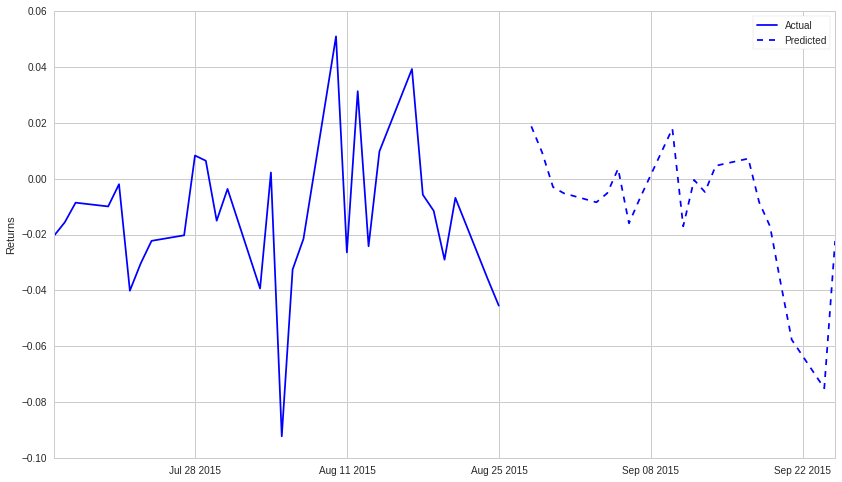

In [12]:
plt.plot(asset1.index[-30:], asset1.values[-30:], 'b-')
plt.plot(predictions.index, predictions, 'b--')
plt.ylabel('Returns')
plt.legend(['Actual', 'Predicted']);

Of course, this analysis hasn't yet told us anything about the quality of our predictions. To check the quality of our predictions we need to use techniques such as out of sample testing or cross-validation. For the purposes of long-short equity ranking systems, using Spearman Correlation details a way to check the quality of a ranking system.

##Important Note
Any of these individual predictions will probably be inaccurate. Industry-quality modeling makes predictions for thousands of assets and relies on broad tends holding. If you had a predictive model with a 51% success rate, you would not make one prediction and bet all your money on it. You would make thousands of predictions and divide your money between them.